<a href="https://colab.research.google.com/github/moon-123/RL-Tutorial-Study/blob/main/CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CartPole

In [ ]:
!pip3 install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.7 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

In [ ]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# interactive mode
plt.ion()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Transition = namedtuple('Transiti',
                        ('state', 'action', 'next_state', 'reward'))

### Memory
* DQN을 학습하기 위해 필요함
* 변천기를 기억함
* 나중에 메모리를 사용하기 위함

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Model
* 3개의 선형 레이어로 구성
n_observations -> 128 -> relu -> 128 ->

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

# Training

### Hyperparameters and utilities

```
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

```

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [ ]:
# Get number of actions from gym action space
# 이미 정의된 action_space 수를 반환. cart pole은 left, right로 두개임
n_actions = env.action_space.n

# n_actions = 2

In [ ]:
# Get the number of state observations
# reset후 초기 상태 반환, 랜덤값?
state, info = env.reset()

In [ ]:
n_observations = len(state)
n_observations

# state가 왜 4개?

4

In [ ]:
policy_net = DQN(n_observations, n_actions).to(device)

target_net = DQN(n_observations, n_actions).to(device)

# 왜 정책net과 타켓net을 따로 만드는지?

In [ ]:
target_net

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
target_net.load_state_dict(policy_net.state_dict())

# 왜?
target_net

# 두 모델을 같은 조건에서 시작하기 위해


DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)

In [ ]:
steps_done = 0

<img src="https://cdn.mathpix.com/snip/images/lr5ddoi5fqxTy9j1Ahk0EiAFMFuzOf9ktCMJeiAH4Ko.original.fullsize.png"/>

* 이 코드는 강화 학습에서 사용되는 epsilon 값을 업데이트하는 방법을 구현한 것입니다. 주어진 코드에서는 epsilon 값(eps_threshold)을 새롭게 계산하고 있습니다.

* EPS_START: 학습 시작 시의 epsilon 값입니다. 이 값은 초기에 탐험을 위해 높게 설정됩니다.
* EPS_END: 학습 종료 시의 최종 epsilon 값입니다. 이 값은 작게 설정되어 무작위 탐색을 줄이고 학습된 정책을 활용합니다.
* EPS_DECAY: epsilon이 감소하는 비율을 결정합니다. 이 값이 클수록 epsilon이 빠르게 감소합니다.
* steps_done: 현재까지 에이전트가 수행한 총 단계 수입니다. 이 값은 시간이 지남에 따라 증가하며, 감소하는 epsilon 값에 영향을 줍니다.
수식적으로, epsilon 값을 업데이트하는 방법은 다음과 같습니다:

    * (EPS_START - EPS_END): 초기 epsilon 값과 최종 epsilon 값의 차이를 구합니다. 이는 epsilon이 감소하는 범위를 나타냅니다.
    * math.exp(-1. * steps_done / EPS_DECAY): 수행한 단계 수에 따라 epsilon의 감소를 결정합니다. 단계 수가 증가할수록 지수 함수의 값은 작아지므로 epsilon 값의 감소가 더 빠르게 이루어집니다.
    최종적으로 최종 epsilon 값인 EPS_END에 위의 두 값의 곱을 더하여 새로운 epsilon 값을 계산합니다.
    이 방법을 통해 학습 초기에는 탐험을 위한 무작위 행동이 더 자주 선택되고, 시간이 지남에 따라 학습된 정책을 활용하는 비율이 높아지게 됩니다.

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # sample이 eps_threshold를 넘으면
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)

    # 그게 아니면 가능한 행동 중에서 무작위로 하나를 샘플링하여 선택
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


In [ ]:
episode_durations = []

In [ ]:
def plot_durations(show_result=False):
    plt.figure(1)
    duration_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')

    plt.plot(duration_t.numpy())

    '''
    duration_t.unfold(0, 100, 1): duration_t라는 시계열 데이터를 100의 길이를 가진 윈도우로 나눕니다. 이 때, 각 윈도우는 1만큼 씩 이동하며 겹치지 않습니다. 이 작업은 PyTorch의 unfold 함수를 사용하여 수행됩니다. 이렇게 하면 각 윈도우에 대한 데이터가 포함된 2차원 텐서가 생성됩니다.

    .mean(1): 각 윈도우의 평균을 계산합니다. 여기서 1은 텐서의 두 번째 차원(열)을 나타냅니다. 따라서 이 작업을 수행하면 각 윈도우의 평균이 포함된 1차원 텐서가 생성됩니다.

    .view(-1): 평균값들을 1차원으로 펼칩니다. 이렇게 하면 최종적으로 각 윈도우의 평균으로 이루어진 1차원 텐서가 생성됩니다.

    torch.cat((torch.zeros(99), means)): 평균값들 앞에 99개의 0 값을 추가합니다. 이는 처음 몇 개의 평균값을 0으로 설정하여, 초기 데이터의 영향을 줄이고 부드러운 추세를 얻기 위함입니다.
    '''

    if len(duration_t) >= 100:
        means = duration_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))

        plt.plot(means.numpy())

    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)

        else:
            display.display(plt.gcf())





### Training loop


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


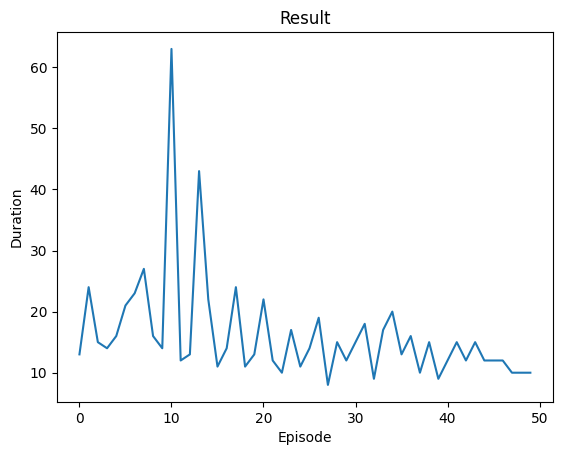

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# 1. 강화학습 원리
* state, action, reward
* state와 action을 반복

# 2.

# Model Visualization

In [ ]:
!pip install torchviz

In [ ]:
from torchviz import make_dot


In [ ]:
# 모델 초기화
n_observations = 10  # 입력 특성의 수
n_actions = 5  # 출력 액션의 수
model = DQN(n_observations, n_actions)

# 더미 입력 데이터 생성
dummy_input = torch.randn(1, n_observations)

# forward pass를 호출하고 그래프 생성
output = model(dummy_input)
graph = make_dot(output, params=dict(model.named_parameters()))

# 그래프를 이미지 파일로 저장 또는 화면에 표시
# graph.render("dqn_model", format="png")  # 파일로 저장
graph.view()  # 그래프를 화면에 표시

'Digraph.gv.pdf'